**Date : 02.06.2018**

**Mathieu LAMIOT, Sohyeong KIM**

# Chapter 4: Deep Learning (Part 1) - Data preprocessing


Part 1
------------


The objective of this first part is to learn about simple data curation practices. Data curation (for machine learning) consists basically in analyse, label, and separate in classes your input data.  In section two, you used pre-curated and separated data from the INRIA's person data set. Your first task is to create your training/testing sets by hand and analyse how well "balance" they are. 

**Objectives** 
In the following sections, you will use this part to "feed" both, a classic _Swallow_ (not-Deep) classification using handcrafted features and a Deep (kind of Deep) neuronal network. Your task will consist in analyse the accuracy of the aforementioned classification based on the amount of data available; from few hundred of samples to the full data-set.

In this section we will provide the general steps and, as in the previous section, you will be asked to search in the function parameters and syntaxis in users documentation.


## Dataset 

In this last section of the course we will use the the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like _real data_: it's not trivial, and the data is a lot less 'clean' than MNIST.


### Libraries: 

Be sure that you can import all the libraries below, in addition, for next chapter you will make use of the tensor flow library to implement the used neuronal network. Be sure to be able to import it as: 

`` import tensorflow as tf``

following the documentation page 

https://www.tensorflow.org/install/

We will use only CPU's based training. 



In [1]:
import cv2 as cv
import numpy as np
import os
import math
import tarfile
import scipy
from utils import *
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt
import glob
from six.moves import cPickle as pickle
%matplotlib inline
import tensorflow as tf
import random

C:\Users\agadg\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Download the data. 

As in section 2, you need to download the data and set the input directory. Be sure to have at about ~1 Gb of free space. If the function is not able to download the data, try on the MNIST site. 



In [2]:

# Download the Data
# The following functions will download the data for you and uncompress it

# WARNING:  These varaibles set the input/output paths for ALL the bellow functions.
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '../data/' # Change me to store data elsewhere


def maybe_download(filename, expected_bytes, force=False):
  """
  Downloads a file if not present, and make sure it's the right size!.
  If there's a file with the same name, the function will not try to 
  download the dataset again!
  """

  dest_filename = os.path.join(data_root, filename)
    
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename, 'This may take a while. Please wait.') 
    filename, _ = urlretrieve(url + filename, dest_filename)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'The file ' + dest_filename + 'already exist but seems corrupted. Delete it or download it from the browser!')
  return dest_filename


def maybe_extract(filename, force=False):
  """
  Uncompress the data set for you
  """
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz

  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s dataset (seems to be) already present.\nSkipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    tar.extractall(data_root)
    tar.close()
    
  data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
  print("All setup.")
  return data_folders


In [3]:
# Downloads ifa needed.
large_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
small_filename  = maybe_download('notMNIST_small.tar.gz', 8458043)


Found and verified ../data/notMNIST_large.tar.gz
Found and verified ../data/notMNIST_small.tar.gz


In [4]:
large_folders = maybe_extract(large_filename)
small_folders = maybe_extract(small_filename)

../data/notMNIST_large dataset (seems to be) already present.
Skipping extraction of ../data/notMNIST_large.tar.gz.
All setup.
../data/notMNIST_small dataset (seems to be) already present.
Skipping extraction of ../data/notMNIST_small.tar.gz.
All setup.


In [5]:
large_folders

['../data/notMNIST_large\\A',
 '../data/notMNIST_large\\B',
 '../data/notMNIST_large\\C',
 '../data/notMNIST_large\\D',
 '../data/notMNIST_large\\E',
 '../data/notMNIST_large\\F',
 '../data/notMNIST_large\\G',
 '../data/notMNIST_large\\H',
 '../data/notMNIST_large\\I',
 '../data/notMNIST_large\\J']

In [6]:
small_folders

['../data/notMNIST_small\\A',
 '../data/notMNIST_small\\B',
 '../data/notMNIST_small\\C',
 '../data/notMNIST_small\\D',
 '../data/notMNIST_small\\E',
 '../data/notMNIST_small\\F',
 '../data/notMNIST_small\\G',
 '../data/notMNIST_small\\H',
 '../data/notMNIST_small\\I',
 '../data/notMNIST_small\\J']

---
Problem 1
---------

When working with data, always check your data. 

Create a description of your input data. Describe in a table or list (one for each sample size): 

* Number of classes (characters)
* Number of samples per class
* General information on the image size and number of channels.

Visualize one sample per class bellow for a chosen size (large or small). 

---


The large descriptors contain the 10 number of classes.
The number of sample per class and the shape of each sample is like following: 
[['A', 52912, (28, 28, 3)],
 ['B', 52912, (28, 28, 3)],
 ['C', 52912, (28, 28, 3)],
 ['D', 52912, (28, 28, 3)],
 ['E', 52912, (28, 28, 3)],
 ['F', 52912, (28, 28, 3)],
 ['G', 52912, (28, 28, 3)],
 ['H', 52912, (28, 28, 3)],
 ['I', 52912, (28, 28, 3)],
 ['J', 52911, (28, 28, 3)]]
The example image sample for each class in large descriptor: 


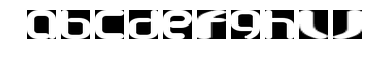

The small descriptors contain the 10 number of classes.
The number of sample per class and the shape of each sample is like following: 
[['A', 1873, (28, 28, 3)],
 ['B', 1873, (28, 28, 3)],
 ['C', 1873, (28, 28, 3)],
 ['D', 1873, (28, 28, 3)],
 ['E', 1873, (28, 28, 3)],
 ['F', 1873, (28, 28, 3)],
 ['G', 1872, (28, 28, 3)],
 ['H', 1872, (28, 28, 3)],
 ['I', 1872, (28, 28, 3)],
 ['J', 1872, (28, 28, 3)]]
The example image sample for each class in small descriptor: 


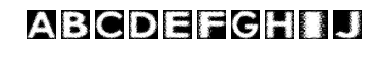

In [7]:
import pprint
pp = pprint.PrettyPrinter(indent=1)

# Define the lists that will contain the descriptions.
large_descriptor = []
small_descriptor = []

for i in range(len(large_folders)):
    info_large_bin = []
    info_small_bin = []
    
    # Folder directory
    large_files = os.listdir(large_folders[i])
    small_files = os.listdir(small_folders[i])

    # Class type (A, B, C, D ... , J )
    info_large_bin.append(large_folders[i][-1])
    info_small_bin.append(small_folders[i][-1])
    
    # Number of images per class
    info_large_bin.append(len(large_files))
    info_small_bin.append(len(small_files))
    
    #Information on image format (height,width,channels)
    large_example = cv.imread(os.path.join(large_folders[i], large_files[0]))
    info_large_bin.append(large_example.shape)
    small_example = cv.imread(os.path.join(small_folders[i], small_files[0]))
    info_small_bin.append(small_example.shape)
    
    # Append info of each class to the descriptor lists
    large_descriptor.append(info_large_bin)
    small_descriptor.append(info_small_bin)

    
# Display
print('The large descriptors contain the {} number of classes.'.format(len(large_descriptor)))
print('The number of sample per class and the shape of each sample is like following: ')
pp.pprint(large_descriptor)
print('The example image sample for each class in large descriptor: ')
fig, ax = plt.subplots(1, 10, figsize=(6, 6))
for classID in range(len(large_descriptor)):
    large_files = os.listdir(large_folders[classID]);
    large_example = cv.imread(os.path.join(large_folders[classID], large_files[1]))
    ax[classID].imshow(large_example)
    ax[classID].axis('off')
plt.show()

print('The small descriptors contain the {} number of classes.'.format(len(small_descriptor)))
print('The number of sample per class and the shape of each sample is like following: ')
pp.pprint(small_descriptor)    
print('The example image sample for each class in small descriptor: ')
fig, ax = plt.subplots(1, 10, figsize=(6, 6))
for classID in range(len(small_descriptor)):
    small_files = os.listdir(small_folders[classID]);
    small_example = cv.imread(os.path.join(small_folders[classID], small_files[0]))
    ax[classID].imshow(small_example)
    ax[classID].axis('off')
plt.show()



Now that you have all your images set up we will load the data into a more manageable format. Since depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. 

To do this we will use pickles!

https://docs.python.org/3.2/library/pickle.html

“Pickling” is the process whereby a Python object (it can be anything!) is converted into a byte stream (binary format), and “unpickling” is the inverse operation. We will use pickles to save the FULL set of images for each character in one pickle. The result will be a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. This process is known as "normalizing the data" or "feature scaling, which is very important to ensure convergence in the optimization step, as well to ensure that the feature space is well defined.

https://en.wikipedia.org/wiki/Feature_scaling


Your task: using the skeleton function bellow you need to: 

* 1) Load all the images in FLOAT format for each class (A,..,J), 1 channel only.
* 2) Transform each image intensities such that the range goes from -125,125 (instead of 0, 256)
* 3) Scale the function so the new range goes from -0.5 to 0.5.

A few images might not be readable, we'll just skip them.

In [8]:

""" Image fixed size  """
image_size  = 28     # Pixel width and height. (28x28)
pixel_depth = 255.0  # Number of levels per pixel. (0,255)

""" There's should be enough data at the end"""
min_num_images_train = 45000;
min_num_images_test  = 1800;



def load_letter(folder, min_num_images):
    
    """ Base function: 

      Complete this function to read a each iamge of a given character (folder)
      Transforms and scale the image to have 0 mean and standard deviation of ~0.5.

      Params: 
          folder: input character folder (e.g. ../data/notMNIST_large/A/)
          min_num_images: minimum number of images you should have per character.

      returns: 
          dataset: Vector containing the fully loaded and scaled dataset.
    """


    image_files = os.listdir(folder)
    
    # Array size (should be preserved)  
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0

    # List of all the images inside the folder  
    for image in image_files:
        image_file = os.path.join(folder, image)
    
        # If the image is not loadable (there are some corrupted images you can skip them) 
        try:
          ##--- CODE HERE:

            ## Load each image and transform them
            image = cv.imread(image_file)  # Load image
            image = np.float32(image[:,:,0]) # Choose one channel and make it as float
            image_scaled= (image*250.0/256.0)-125.0   # Transform the image (step 1)
            image_data = image_scaled/250    # Scale the image (step 2)

          ##--- End of your code.

          # here I check that you load them correctly and save it in the dataset array.  
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data

            num_images = num_images + 1
        
        #except IOError as e:
            #print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        except:
            print('Could not read:', image_file, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]

    # If this theshhold is not met, you are doind something wrong (probably)  
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
 
    #Check this output! 
    # The mean should be very close to 0 i.e < 1 and the std should be less than 0.5.  
    print('Full dataset tensor:', dataset.shape)
    
    # Notice we aree calling this a "tensor"
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset


In [9]:
# Look, Morty, I'm a Pickle!        

# This function calls your pre-defined-function load_letter(folder, min_num_images) and creates the pickle!

def Im_a_pickle(data_folders, min_num_images_per_class, force=False):
    
    """ Base function: 
  
      Loads all the images listed in data_folders and creates a .pickle file
      
      Params: 
          data_folders: list of the folders to pickle (i.e. large_folders, small_folders)
          min_num_images: minimum number of images you should have per character.
      
      returns: 
          dataset_names: Vector containing all the pickles names.
  """
    dataset_names = []

    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
    
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Turning myself into a Pickle! %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

If everything was done correctly we can then call the following functiosn without error!

Notice that we are here considereing the "large" data set as our training data set and the small as our test data set.

In [10]:
train_datasets = Im_a_pickle(large_folders, 45000)
test_datasets  = Im_a_pickle(small_folders, 1800)

../data/notMNIST_large\A.pickle already present - Skipping pickling.
../data/notMNIST_large\B.pickle already present - Skipping pickling.
../data/notMNIST_large\C.pickle already present - Skipping pickling.
../data/notMNIST_large\D.pickle already present - Skipping pickling.
../data/notMNIST_large\E.pickle already present - Skipping pickling.
../data/notMNIST_large\F.pickle already present - Skipping pickling.
../data/notMNIST_large\G.pickle already present - Skipping pickling.
../data/notMNIST_large\H.pickle already present - Skipping pickling.
../data/notMNIST_large\I.pickle already present - Skipping pickling.
../data/notMNIST_large\J.pickle already present - Skipping pickling.
../data/notMNIST_small\A.pickle already present - Skipping pickling.
../data/notMNIST_small\B.pickle already present - Skipping pickling.
../data/notMNIST_small\C.pickle already present - Skipping pickling.
../data/notMNIST_small\D.pickle already present - Skipping pickling.
../data/notMNIST_small\E.pickle al

---
## Problem 2

---------

To corroborate that our data is properly saved and scaled, display one example per class letter (A,...,J), from the train dataset **or** the test dataset. 

To do this you will need to use the ``pickle.load(...)``. Check the documentation above for more details. You can use the inhered matplotlib function to show each example. Include a colorbar showing the __values range of the image__.

---

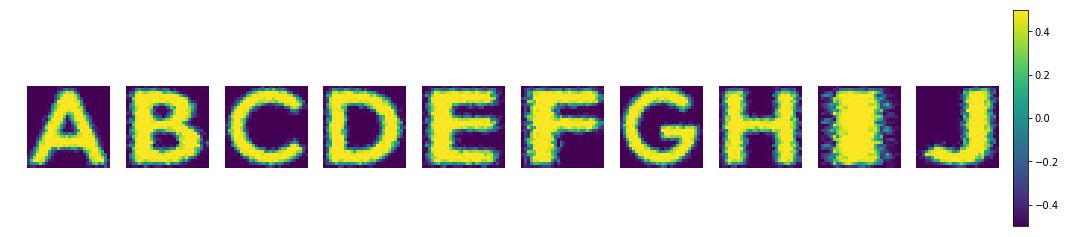

In [11]:
fig, ax = plt.subplots(1, 10, figsize=(20, 10))
graphID = 0;
for pickle_file in  test_datasets:
    dataset = pickle.load(open(pickle_file,'rb')) # Unpickle the file
    im = ax[graphID].imshow(dataset[0,:,:]); # Display the first sample
    ax[graphID].axis('off')
    graphID = graphID + 1;

# Set colorbar location
plt.subplots_adjust( right=0.8, top=0.65)
cax = plt.axes([0.81, 0.25, 0.01, 0.3])

plt.colorbar(im, cax = cax) # Add colorbar

plt.show()


Finally if everything is correct, the above function should contain the full length of each character sample.  The labels will be stored into a separate array of *integers 0 through 9*.

Corroborate that the train_sets are in the order of ~52,000 images, and the train_set in the order of 1,870 images. 

In [12]:
def data_sets_sizes(data_set):
    
    number_files = [];

    """ Base function: 
  
      Loads all the images listed in data_set and return it' s size
    """
    for pickle_file in  data_set:
        # Unpickle the file
        dataset = pickle.load(open(pickle_file,'rb'))  
        # Get the shape of the dataset
        datashape = dataset.shape
        # Retrieve the number of samples
        number_files.append(datashape[0])
        
    # print(number_files)
    return number_files

print('The number of data of each class of train datasets is, ',data_sets_sizes(train_datasets))
print('The number of data of each class of test datasets is, ',data_sets_sizes(test_datasets))

The number of data of each class of train datasets is,  [52909, 52911, 52912, 52911, 52912, 52912, 52912, 52912, 52912, 52911]
The number of data of each class of test datasets is,  [1872, 1873, 1873, 1873, 1873, 1872, 1872, 1872, 1872, 1872]


## Problem 3 
### Creating sub-sampled datasets.


In order to evaluate the performance of our classifiers, we need to create subsets of our data properly randomized; this means that we shouldn't choose always the first set of images to compare since we will introduce a bias because of the sampled order. A very nice post on this topic can be found below in case you wonder if it's worth the trouble.

https://machinelearningmastery.com/randomness-in-machine-learning/


As problem 3 you are asked to write a function: ``sample_training_data(...)`` which should create a training dataset of a given size, containing the same number of samples for each label (-1 or +1 samples) _randomly selected_ from the ``train-dataset``; as well as the labels of the training set coded as integers from 0 (A) to 9 (J). 


Is worth mentioning that is common practice in machine learning to set aside a third data set known as the _validation dataset_. Which is used to prevent overfitting and other training problems. We will not make use of such dataset, however, is worth to check why is used; one nice and short explanation can be found here (it also contains nice code hints relevant to the exercise ;) )

https://machinelearningmastery.com/difference-test-validation-datasets/



In [13]:
#Code here.
def sample_training_data(pickle_files, train_size):

    """ Base function: 
  
      Given a train size returns a ndarray containing a total of 
      <train_size/number_of_clases> samples for each character.
      
      example for train_size = 100, should contain 100/10 = 10 samples of each character. 
      
      The samples should be chose randomly.
      
      Params: 
          pickle_files: list of the pickle files (training set)
          train_size: total length of the new training set
      
      returns: 
          train_dataset: ndarray containing all the training images (properly normalized)
          train_labels : the labels of each selected image. 
  """
    # Initialize the output dataset
    image_size = 28
    train_dataset = np.zeros((train_size,image_size,image_size))
    train_labels = np.zeros(train_size)
    
    # Get the size of every class
    sizes = data_sets_sizes(pickle_files)
    
    # For each class do sampling
    pickleID = 0 # Label of class
    totalID = 0
    for pickle_file in  pickle_files:  #For each class
        dataset = pickle.load(open(pickle_file,'rb')); #Unpickle the file
        
        # Create a list of the first integer up to the length of the class
        full_list = np.arange(sizes[pickleID])
        
        #Randomly selects sample indexes in the class
        picked_samples = random.sample(list(full_list), int(np.floor(train_size/len(sizes)+1)))
        for sampleID in range(0,len(picked_samples)-1): # For each selected sample index 
            train_dataset[totalID,:,:]=dataset[(picked_samples[sampleID]),:,:] # Add the sample to the global set
            train_labels[totalID]=pickleID; #And its label
            totalID = totalID+1;
        
        # This part ensures that we add one additional sample when needed in the case 
        # i.e. when <train_size/number_of_clases>  is not integer
        if(train_size-totalID>(len(pickle_files)-pickleID-1)*int(np.floor(train_size/len(sizes)))):
            train_dataset[totalID,:,:]=dataset[(picked_samples[len(picked_samples)-1]),:,:];
            train_labels[totalID]=pickleID;
            totalID = totalID+1;
        
        # Next class label
        pickleID = pickleID +1;

    
    return train_dataset, train_labels
  

# EXAMPLE OF USE
train_size = 20000
valid_size = 10000
test_size = 10000

train_dataset, train_labels = sample_training_data(train_datasets, train_size);
test_dataset, test_labels = sample_training_data(test_datasets, test_size);
valid_dataset, valid_labels = sample_training_data(train_datasets, valid_size);
print('Training size: ', train_dataset.shape, '\nLabel vector size:',train_labels.shape)
print('Testing size: ', test_dataset.shape, '\nLabel vector size:',test_labels.shape)

Training size:  (20000, 28, 28) 
Label vector size: (20000,)
Testing size:  (10000, 28, 28) 
Label vector size: (10000,)


Finally, you need to randomize the vector so it doesn't follow any specific order: like first all the A characters and then the 'B' characters, and so on 

```(A, A, ..., A , B, B, ..., B, C, C, ...,C,... )```.


In [14]:
# Define a function to randomize THE ORDER of a given dataset.
# Be sure that the dataset and the labels are shuffled in the same order so they MATCH.

def randomize(dataset, labels):
    #code here
    # Creates a permutation pattern that will be applied to the set and labels.
    permutation_pattern = np.random.permutation(dataset.shape[0])
    # Apply permutation to the set
    shuffled_dataset=np.take(dataset,permutation_pattern,axis=0)
    # Apply the same permutation to the labels
    shuffled_labels=np.take(labels,permutation_pattern,axis=0) 
    
    return shuffled_dataset, shuffled_labels


# Shuffle both train and test data sets
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels   = randomize(test_dataset, test_labels)


---
Problem 4
---------

Show us that your method works and both datasets are coherent with the labels. You can display the shuffled order and show the first images in both datasets. They should match the labels.

---

The label of each character is :  A=0 ; B=1; C=2; D=3; E=4; F=5; G=6; H=7; I=8; J=9

First 10 items in Train Dataset :


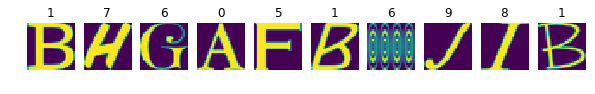

First 10 items in Test Dataset :


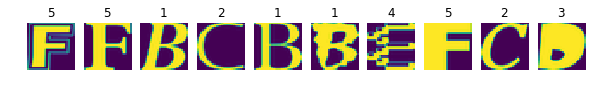

In [15]:
print('The label of each character is :  A=0 ; B=1; C=2; D=3; E=4; F=5; G=6; H=7; I=8; J=9\n')

# Choose the part of data we want to visualize
train_dataset_part = train_dataset[0:10]
train_labels_part = train_labels[0:10]
test_dataset_part = test_dataset[0:10]
test_labels_part = test_labels[0:10]

print('First 10 items in Train Dataset :')
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
for ax, im, nm in zip(axes.ravel(), train_dataset_part, train_labels_part):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(int(nm))
plt.show()

print('First 10 items in Test Dataset :')
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
for ax, im, nm in zip(axes.ravel(), test_dataset_part, test_labels_part):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(int(nm))
plt.show()


---
Problem 5
---------

By default, this dataset might contain a lot of overlapping samples, including training data that are also contained in the test set. The overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap but are actually ok if you expect to see training samples recur when you use it.

Measure how much overlap there is between training, validation and test samples. 

- Give the number of overlapping samples in the test set for the full dataset.
- What about near duplicates between datasets? (images that are almost identical), provide a __estimation__ based in any metric or function to evaluate similitude with a given threshold.  
- Modify your ``sample_training_data``function and provide a curated train and test dataset removing the very similar samples from one of them. 
---

Since there exist duplicates in the full dataset, we will first try to remove those duplicate from the full dataset.

If we compare the dataset using nested loops and matrix comparison, the processing time would be very long(especially when we have more than 50k data to compare). To make this feasible in our case, the best option is to use a hash function. 

For example, cryptographic hashing algorithms can be used to identify exact duplicate of the images since very tiny changes in the input file will result in a substantially different hash when using cryptographic hashing algorithms. Below function 'remove_duplicate_data' removes the duplicate data from full dataset (A, B, ... J). 

In [16]:
def list_duplicates(seq):
    '''
    This function return the index of the same element that are already in previously. 
    If  a = [1,2,3,2,3,5,6], 
    list_duplicates(a) will return [3,4]
    '''
    seen = set()
    seen_add = seen.add
    return [idx for idx,item in enumerate(seq) if item in seen or seen_add(item)]

In [17]:
import hashlib

def remove_duplicate_data(dataset):
    
    clean_set = list(dataset.copy())
    duplicates =[]
    
    # Compute the hash of all images
    dataset_hash = np.array([hashlib.sha256(img).hexdigest() for img in dataset])
    
    # Find indicies that are duplicated
    duplicate_idx = list_duplicates(dataset_hash)
    duplicate_idx.sort(reverse = True) # Reverse the index order
    
    # Remove the duplicates from the dataset
    for i in duplicate_idx:
        duplicates.append(clean_set.pop(i))
        
    return clean_set, duplicates

5807 duplicate data are removed from the dataset.
In the cleaned dataset, there is 47102 data.
Example of the some of duplicated images


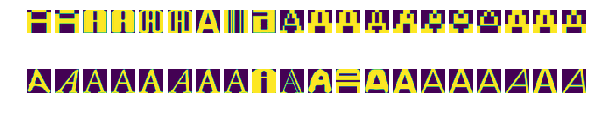

In [18]:
# Example of the duplicate data on one class
testset = pickle.load(open(train_datasets[0],'rb')); #Unpickle the file - class A
clean_set, duplicates = remove_duplicate_data(testset)

print('{} duplicate data are removed from the dataset.'.format(len(duplicates)))
print('In the cleaned dataset, there is {} data.'.format(len(clean_set)))

# Visualize the some duplicated data
print('Example of the some of duplicated images')
fig, axes = plt.subplots(2, 20, figsize=(10, 2))
for ax, im in zip(axes.ravel(), duplicates):
    ax.imshow(im)
    ax.axis('off')
plt.show()

Now, we want to check how many data is simiar each other between test and training set. In this case, we will consider not only the exact duplicates but also the similar images since these similar images can skew the result as the same way as the exact duplicates. If cryptographic hash function is applied to images that only a single bit is different, the result can be very different. Therefore, we will use perceptual hash function instead of cryptographic hash function to find the similar images. The perceptural hash function is constructing a hash value that uniquely identifies an input image based on the contents of an image. Among many perceptural hash algorithm, we decided to use  difference hashing algorithm because this algorithm is robust to scaling transformation, brightness or contrast. 

The function 'dhash' is the perceptural hash algorithm that convert image to hash. The function 'hamdist' is the function which compute the hamming distance between two input strings. The 'compute_similarity' function computes difference hash of all elements in the input datasets and then check the number of hash included in both sets. The more similar data that both sets have, the more the same hashes there will be.

In [19]:
def dhash(image, hashSize=8):
    '''
        The implementation of difference hashing function algorithm.
        
        Given input as an image, the output is the hash.
    '''    
    # resize the input image, adding a single column (width) 
    # to ensure that the resulting image hash will match similar images 
    # regardless of their initial spatial dimensions.
    resized = cv.resize(image, (hashSize + 1, hashSize))
 
    # compute the (relative) horizontal gradient between adjacent column pixels
    # Tests if adjacent pixels are brighter or darker
    diff = resized[:, 1:] > resized[:, :-1]
    flat_diff = diff.flatten()

    # Convert the binary array to a hexadecimal string hash
    decimal_value = 0
    hex_string = []
    for index, value in enumerate(flat_diff):
        if value:
            decimal_value += 2**(index % 8)
        if (index % 8) == 7:
            hex_string.append(hex(decimal_value)[2:].rjust(2, '0'))
            decimal_value = 0
    
    return ''.join(hex_string)

In [20]:
def hamdist(str1, str2):
    """
    Count the # of differences between equal length strings str1 and str2
    """
    diffs = 0
    for ch1, ch2 in zip(str1, str2):
            if ch1 != ch2:
                    diffs += 1
    return diffs

In [21]:
def compute_similarity(dataset1, dataset2):
    '''
        Find similar hashes between two datasets.
    '''
    
    # Compute the difference hash of all images
    dataset_hash1 = np.array([dhash(img) for img in dataset1])
    dataset_hash2 = np.array([dhash(img) for img in dataset2])
    
    # Count the hash that are similar 
    similar_hash = len(np.intersect1d(dataset_hash1, dataset_hash2))
    
    similar_matrix = np.zeros((len(dataset_hash1),len(dataset_hash2)))
    # Compute the haming distance between all images
    for i, hash1 in enumerate(dataset_hash1): 
        for j, hash2 in enumerate(dataset_hash2):   # Fill the matrix with hamming distance
            similar_matrix[i,j]=hamdist(hash1, hash2)

    return similar_hash, similar_matrix

We have modified the 'sample_trainig_data' function written in the previous question. The main modification is that we first remove the duplicates in each class and then use cleaned dataset when creating our training/test sets. To ensure random selection within one class, we used 'np.random.permutation' function to shuffle the indices of the cleaned dataset and choose first N as a trianing set and the next M as a validation set(if indicated as an input). 

In [26]:

def sample_training_data(pickle_files, train_size, valid_size=0):

    """ Base function: 
  
      Given a train size returns a ndarray containing a total of 
      <train_size/number_of_clases> samples for each character.
      
      example for train_size = 100, should contain 100/10 = 10 samples of each character. 
      
      The samples should be chose randomly.
      
      Params: 
          pickle_files: list of the pickle files (training set)
          train_size: total length of the new training set
          valid_size : total length of the valid set
      
      returns: 
          train_dataset: ndarray containing all the training images (properly normalized)
          train_labels : the labels of each selected image. 
  """
    # Initialize the output dataset
    image_size = 28
    train_dataset = np.zeros((train_size,image_size,image_size))
    train_labels = np.zeros(train_size)
    valid_dataset = np.zeros((valid_size,image_size,image_size))
    valid_labels = np.zeros(valid_size)
    
    # Get the size of every class
    sizes = data_sets_sizes(pickle_files)
    num_class = len(sizes) # number of classes
    
    # For each class do sampling
    pickleID = 0 # Label of class
    totalID = 0 
    validID = 0
    for pickle_file in  pickle_files:  #For each class
        dataset = pickle.load(open(pickle_file,'rb')); #Unpickle the file
        
        # Clean the duplicates from the full data set per class
        clean_set, duplicates = remove_duplicate_data(dataset)
        print('Class {} : Removing {} duplicate data, leaving {} data in the cleaned dataset.'.format(pickleID, 
                                                                                                      len(duplicates),
                                                                                                      len(clean_set)))
        # Create a list of the first integer up to the length of the class
        full_list = np.arange(len(clean_set))
        
        #Randomly selects sample indices in the class
        shuffled_list = np.random.permutation(full_list)
        # Take the first N samples that corresponds to the shuffled indices as training set
        picked_samples = shuffled_list[0:int(np.floor(train_size/num_class+1))]
        for sampleID in range(0,len(picked_samples)-1):   # For each selected sample index 
            #print(picked_samples[sampleID])
            train_dataset[totalID,:,:]=clean_set[picked_samples[sampleID]]  # Add the sample to the global set
            train_labels[totalID]=pickleID; #And its label
            totalID = totalID+1;
        
        # This part ensures that we add one additional sample when needed in the case 
        # i.e. when <train_size/number_of_clases>  is not integer
        if(train_size-totalID>(len(pickle_files)-pickleID-1)*int(np.floor(train_size/num_class))):
            train_dataset[totalID,:,:]=clean_set[picked_samples[len(picked_samples)-1]]#,:,:];
            train_labels[totalID]=pickleID;
            totalID = totalID+1;
        
        # Take the next M samples that corresponds to the shuffled indices as valid set
        picked_samples2 = shuffled_list[int(np.floor(train_size/num_class+1)):int(np.floor(train_size/num_class+1))+int(np.floor(valid_size/num_class+1))]
        for sampleID in range(0,len(picked_samples2)-1):   # For each selected sample index 
            valid_dataset[validID,:,:]=clean_set[picked_samples2[sampleID]]  # Add the sample to the global set
            valid_labels[validID]=pickleID; # And its label
            validID = validID+1;

        if(valid_size-validID>(len(pickle_files)-pickleID-1)*int(np.floor(valid_size/num_class))):
            valid_dataset[validID,:,:]=clean_set[picked_samples2[len(picked_samples2)-1]]#,:,:];
            valid_labels[validID]=pickleID;
            validID = validID+1;
        
        # Next class label
        pickleID = pickleID +1;

    
    return train_dataset, train_labels, valid_dataset, valid_labels
  

# EXAMPLE OF USE
train_size = 20000
valid_size = 10000
test_size = 10000

print('------- Creating training datasets and validation datasets --------')
train_dataset, train_labels, valid_dataset, valid_labels = sample_training_data(train_datasets, train_size, valid_size=10000);
print('------- Finished creating --------')
print('Training size: ', train_dataset.shape, ' -- Label vector size:',train_labels.shape)
print('Validation size: ', valid_dataset.shape, ' -- Label vector size:',valid_labels.shape)

print('\n ------- Creating testing datasets --------')
test_dataset, test_labels, dummy, dummy2 = sample_training_data(test_datasets, test_size);
print('------- Finished creating --------')
print('Testing size: ', test_dataset.shape, ' -- Label vector size:',test_labels.shape)

------- Creating training datasets and validation datasets --------
Class 0 : Removing 5807 duplicate data, leaving 47102 data in the cleaned dataset.
Class 1 : Removing 5630 duplicate data, leaving 47281 data in the cleaned dataset.
Class 2 : Removing 6258 duplicate data, leaving 46654 data in the cleaned dataset.
Class 3 : Removing 6180 duplicate data, leaving 46731 data in the cleaned dataset.
Class 4 : Removing 5958 duplicate data, leaving 46954 data in the cleaned dataset.
Class 5 : Removing 6068 duplicate data, leaving 46844 data in the cleaned dataset.
Class 6 : Removing 5822 duplicate data, leaving 47090 data in the cleaned dataset.
Class 7 : Removing 6730 duplicate data, leaving 46182 data in the cleaned dataset.
Class 8 : Removing 11739 duplicate data, leaving 41173 data in the cleaned dataset.
Class 9 : Removing 6253 duplicate data, leaving 46658 data in the cleaned dataset.
------- Finished creating --------
Training size:  (20000, 28, 28)  -- Label vector size: (20000,)
Va

Finally, we check how similar it is between the datasets that we have created. The output matrix of the function 'compute_similarity' is storing the hamming distance between all the images in both sets. Considering images A and B, the smaller the hamming distance of their hash, the more similar they are. We plotted heatmap of similarity matrix so that we have a better understanding of our sampled data. 

Since we have not yet shuffled the order of the training/test dataset, the data are order by the class(from A to J). We can see from the heatmap of elements in training dataset that the hamming distances are smaller within each classes and larger between different classes. From the result of calculating similarites between datasets, we could get a feeling of how much similar they are. 

Here we have computed the similarity for whole dataset that we have sampled since the size is relatively small. However in real big data cases, it is recommended to select some number of most representative data for each class from each dataset and then compute the similarities between them. 

Wall time: 17min 40s


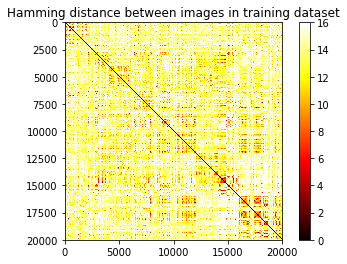

In [23]:
# Between training dataset's elements
%time dummy, hamdist_matrix = compute_similarity(train_dataset, train_dataset)
plt.imshow(hamdist_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Hamming distance between images in training dataset')
plt.show()

Wall time: 9min 11s
There are 744 overlapping hashs between train set and test set.


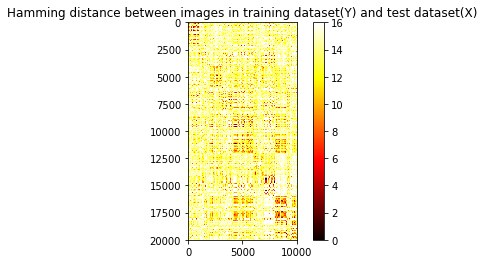

In [24]:
# Between Training dataset and Test dataset
%time similar_hash2, hamdist_matrix2 = compute_similarity(train_dataset, test_dataset)
print('There are {} overlapping hashs between train set and test set.'.format(similar_hash2))
plt.imshow(hamdist_matrix2, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Hamming distance between images in training dataset(Y) and test dataset(X)')
plt.show()

Wall time: 5min 44s
There are 623 overlapping hashs between train set and validation set.


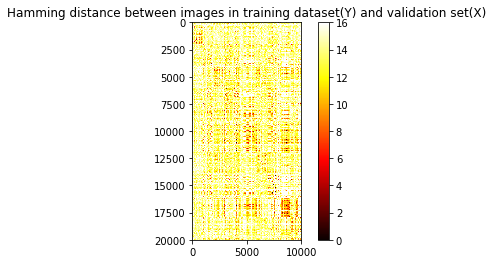

In [25]:
# Between Training dataset and Validation dataset
%time similar_hash3, hamdist_matrix3 = compute_similarity(train_dataset, valid_dataset)
print('There are {} overlapping hashs between train set and validation set.'.format(similar_hash3))
plt.imshow(hamdist_matrix3, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Hamming distance between images in training dataset(Y) and validation set(X)')
plt.show()

Wall time: 3min 11s
There are 506 overlapping hashs between test set and validation set.


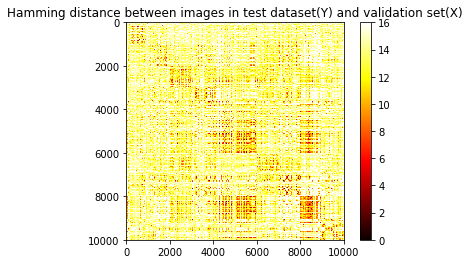

In [26]:
# Between Test dataset and Validation dataset
%time similar_hash4, hamdist_matrix4 = compute_similarity(test_dataset, valid_dataset)
print('There are {} overlapping hashs between test set and validation set.'.format(similar_hash4))
plt.imshow(hamdist_matrix4, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Hamming distance between images in test dataset(Y) and validation set(X)')
plt.show()

Below function 'remove_similar_data' is removing similar data between two datasets and its corresponding labels. The number of removed images is bigger than the number of overlapping hashs computed above. This is happening because in dataset1 there  may exist multiple elements that are similar to one element in dataset2. (having same perceptual hash value) 

In [27]:
def remove_similar_data(dataset1, dataset2, labels1):
    
    '''
        Removes the data and its corresponding labels in dataset1 which are similar to dataset2. 
        The order of the dataset1 and dataset2 is important in this function. 
    
    '''
    
    # Initialize the variables
    clean_set = list(dataset1.copy())
    clean_labels = list(labels1.copy())
    similar_idx = [] # list of indexes
    
    # Compute the difference hash(perceptual hash) of all images
    dataset_hash1 = np.array([dhash(img) for img in dataset1])
    dataset_hash2 = np.array([dhash(img) for img in dataset2])
    
    # Find indicies that are similar image
    for i, hash1 in enumerate(dataset_hash1):
        same_hash = np.where(dataset_hash2 == hash1)
        if len(same_hash[0]):
            similar_idx.append(i)
    similar_idx.sort(reverse = True) # Reverse the index order

    # Remove the similar images from the dataset
    for i in similar_idx:
        clean_set.pop(i) # Remove the data
        clean_labels.pop(i) # Remove the image
        
    return np.array(clean_set), np.array(clean_labels)


# Example of usage
sanit_test_dataset, sanit_test_labels = remove_similar_data(test_dataset, train_dataset, test_labels)
sanit_valid_dataset, sanit_valid_labels = remove_similar_data(valid_dataset, train_dataset, valid_labels)
print('Sanitized Testing size: ', sanit_test_dataset.shape, ' -- Label vector size:',sanit_test_labels.shape)
print('Sanitized Validation size: ', sanit_valid_dataset.shape, ' -- Label vector size:',sanit_valid_labels.shape)

Sanitized Testing size:  (8343, 28, 28)  -- Label vector size: (8343,)
Sanitized Validation size:  (8738, 28, 28)  -- Label vector size: (8738,)


Since our next part of assignment requires 200,000 number of training dataset and 10,000 number of validate dataset and 10,000 number of test dataset, we resampled the datasets and stored them. Note that we don't run the 'remove_similar_data' on those huge sets. Hence those sets are only curated once for duplicates, but not for similar data.

In [27]:
train_size2 = 200000
test_size2 = 10000

print('------- Creating training datasets and validation datasets --------')
train_dataset2, train_labels2, valid_dataset2, valid_labels2 = sample_training_data(train_datasets, train_size2, valid_size=10000);
print('------- Finished creating --------')
print('Training size: ', train_dataset2.shape, ' -- Label vector size:',train_labels2.shape)
print('Validation size: ', valid_dataset2.shape, ' -- Label vector size:',valid_labels2.shape)

print('\n ------- Creating testing datasets --------')
test_dataset2, test_labels2, dummy, dummy2 = sample_training_data(test_datasets, test_size2);
print('------- Finished creating --------')
print('Testing size: ', test_dataset2.shape, ' -- Label vector size:',test_labels2.shape)


# Shuffle both train and test data sets and validation sets
print('\n ------- Shuffling the dataset  --------')
train_dataset2, train_labels2 = randomize(train_dataset2, train_labels2)
test_dataset2, test_labels2   = randomize(test_dataset2, test_labels2)
valid_dataset2, valid_labels2   = randomize(valid_dataset2, valid_labels2)

print('\n ------- Storing the dataset for next part --------')
# Store the sampled data
# Data path
pickle_file = 'notMNIST.npy'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset2,
    'train_labels': train_labels2,
    'valid_dataset': valid_dataset2,
    'valid_labels': valid_labels2,
    'test_dataset': test_dataset2,
    'test_labels': test_labels2,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
print('\n ------- Storing the dataset for next part --------')

------- Creating training datasets and validation datasets --------
Class 0 : Removing 5807 duplicate data, leaving 47102 data in the cleaned dataset.
Class 1 : Removing 5630 duplicate data, leaving 47281 data in the cleaned dataset.
Class 2 : Removing 6258 duplicate data, leaving 46654 data in the cleaned dataset.
Class 3 : Removing 6180 duplicate data, leaving 46731 data in the cleaned dataset.
Class 4 : Removing 5958 duplicate data, leaving 46954 data in the cleaned dataset.
Class 5 : Removing 6068 duplicate data, leaving 46844 data in the cleaned dataset.
Class 6 : Removing 5822 duplicate data, leaving 47090 data in the cleaned dataset.
Class 7 : Removing 6730 duplicate data, leaving 46182 data in the cleaned dataset.
Class 8 : Removing 11739 duplicate data, leaving 41173 data in the cleaned dataset.
Class 9 : Removing 6253 duplicate data, leaving 46658 data in the cleaned dataset.
------- Finished creating --------
Training size:  (200000, 28, 28)  -- Label vector size: (200000,)


---
Problem 6
---------

Let's get an idea of what a basic classifier can give you on this data. 

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. 

Hint: you can use the ```LogisticRegression``` or ```LogisticRegressionCv``` model from sklearn.linear_model.

Provide a score for the prediction over the full test data set. You can use any metric from the previous chapters or an implemented one like the ```cross_val_score``` form sklearn which is more accurate.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

A good choice of parameters (and regularization method) can give you results up to the 89%



```
#Samples: 50 ---> Score: 0.471428571429
#Samples: 100 ---> Score: 0.605865717935
#Samples: 1000 ---> Score: 0.760772183027
#Samples: 5000 ---> Score: 0.812826972435 
```



---

In [31]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import cross_val_score

def train_and_validate(num_examples):
    global train_dataset, train_labels
    global test_dataset, test_labels
    global image_size
    score = np.zeros(5)
    for mc in range(0,5):
        test = np.zeros((len(test_labels),image_size**2));
        for sampleID in range(0,len(test_labels)):
            test[sampleID,:]=test_dataset[sampleID,:,:].flatten();

        train = np.zeros((num_examples,image_size**2));
        for sampleID in range(0,num_examples):
            train[sampleID,:]=train_dataset[sampleID,:,:].flatten();
        lrcv = LogisticRegressionCV()
        lrcv.fit(train,train_labels[0:num_examples])
        score[mc] = lrcv.score(test,test_labels)
    return score.mean()

C:\Users\shgold\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
training_sizes = [50, 100, 1000, 5000]

print("Cross Validation Score\n")
for size in training_sizes:
    score = train_and_validate(size)
    print("Samples:", size,"---> Score:", score)
    
    
#Samples: 50 ---> Score: 0.471428571429
#Samples: 100 ---> Score: 0.605865717935
#Samples: 1000 ---> Score: 0.760772183027
#Samples: 5000 ---> Score: 0.812826972435


Cross Validation Score



C:\Users\shgold\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Samples: 50 ---> Score: 0.4563
Samples: 100 ---> Score: 0.6392
Samples: 1000 ---> Score: 0.8530999999999999
Samples: 5000 ---> Score: 0.8754
